In [1]:
import os, sys, time, datetime, random

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
# conda install pytorch torchvision -c pytorch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import cv2
# conda install -c conda-forge opencv


# Load video

In [2]:
videopath = '../data/robot_parcours_1.avi'

In [3]:
# Create an vector of frames with values from 0 to 1 and invert colors

from skimage.color import rgb2gray

cap = cv2.VideoCapture(videopath)
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = img/255. # values from 0 to 1 and negative
    img = rgb2gray(img)
    img = abs(img - 1.) # invert colors

    frames.append(img)
    
    if cv2.waitKey(1) == ord('q'):
        break
        
cap.release()

In [4]:
shape_frame = frames[0].shape
n_frames = len(frames)

print(shape_frame)
print(n_frames)

(480, 720)
42


In [5]:
# shape_number = (28,28)
shape_number = (32,32) #This is the size of the sliding windows

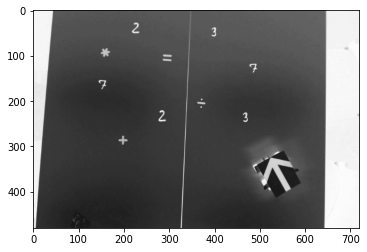

In [6]:
fig, ax = plt.subplots(1) 
ax.imshow(frames[0], cmap='gray')

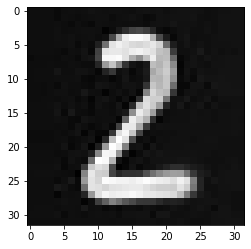

In [7]:
fig, ax = plt.subplots(1) 

# plt.imshow(frames[0][218:246,270:298], cmap='gray')
ax.imshow(frames[0][217:249,268:300], cmap='gray')

In [204]:
# Create height * width image windows, many windows for each frame

stride = (2,2)
windows = []

y_range = range(0, shape_frame[0] - shape_number[0], stride[0])
x_range = range(0, shape_frame[1] - shape_number[1], stride[1])

pos_xy = []
for j in y_range:
    for i in x_range:
        pos_xy.append(np.array([i,j]))
pos_xy = np.array(pos_xy)
        
for frame in frames:
    sliding_w = []
    for j in y_range:
        for i in x_range:
            sliding_w.append(frame[j:j+shape_number[0],i:i+shape_number[1]])
    windows.append(sliding_w)

In [205]:
print(windows[0][0].shape)
print(pos_xy.shape)

(32, 32)
(77056, 2)


# Number classifier

In [206]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [207]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [33]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size) 
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

# Divide by 255.
train_images = train_images / 255.
test_images = test_images / 255.

# Preprocessing
train_images_p = preprocess_images(train_images[:10000])
test_images_p = preprocess_images(test_images)


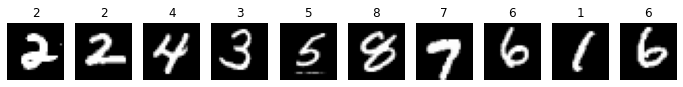

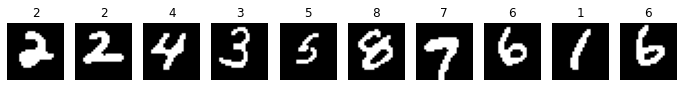

In [34]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=test_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images_p[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

## CNN trained with MNIST

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

In [36]:
train_input = torch.Tensor(train_images_p).view(-1,1,28,28).float()
test_input = torch.Tensor(test_images_p).view(-1,1,28,28).float()
train_target = torch.Tensor(train_labels).long()
test_target = torch.Tensor(test_labels).long()

print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [37]:
TRAIN = False
PATH = './nmist_comp_1000_iter.pth'
mini_batch_size = 50

In [38]:
class NClassifierNet(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use 
        in the forward pass.
        """
        super(NClassifierNet, self).__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size = 3) # 28 -> 26 (13) / 14 -> 12
        self.bn1 = nn.BatchNorm2d(num_features = 16) 
        self.conv2 = nn.Conv2d(16,32, kernel_size = 3) # 26 -> 24 (13 -> 11 (5))/ 12 -> 10
        self.bn2 = nn.BatchNorm2d(num_features = 32)
        self.conv3 = nn.Conv2d(32,64, kernel_size = 3) # 24 -> 22 / 10 -> 8
        self.bn3 = nn.BatchNorm1d(num_features = 64*3*3)
        self.fc1 = nn.Linear(64*3*3, 10) # -> nn.Linear(64*8*8,1024)
#         self.bn4 = nn.BatchNorm1d(num_features = 512)
#         self.fc2 = nn.Linear(512,256)
#         self.bn5 = nn.BatchNorm1d(num_features = 256)
#         self.fc3 = nn.Linear(256,10)

        

    def forward(self, xA):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        A = F.relu(F.max_pool2d(self.conv1(xA),kernel_size = 2, stride = 2))
        A = F.relu(F.max_pool2d(self.conv2(self.bn1(A)),kernel_size = 2, stride = 2))
        A = F.relu(self.conv3(self.bn2(A)))
        A = F.relu(self.fc1(self.bn3(A.view(-1, 64*3*3))))
#         A = F.relu(self.fc2(self.bn4(A)))
#         A = F.relu(self.fc3(self.bn5(A)))

        return A

In [39]:
eta = 1e-3
model, criterion = NClassifierNet(), nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta, betas=[0.99,0.999])

if TRAIN:
    for e in range(20):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            lossA = criterion(output, train_target.narrow(0, b, mini_batch_size))
            loss = lossA
            model.zero_grad()
            loss.backward()
            sum_loss += loss.item()
            # with torch.no_grad():
            #     for p in model.parameters():
            #         p -= eta * p.grad
            optimizer.step()
        print(e, sum_loss)
        
        torch.save(model.state_dict(), PATH)

In [46]:
model.load_state_dict(torch.load(PATH))

correctA = 0
total = 0

with torch.no_grad():
    for e in range(1):
        outputs = model(test_input)
        _, predictedA = torch.max(outputs, 1)
        total += test_target.size(0)

        correctA += (predictedA == test_target).sum().item()
        
print('Accuracy of the network on the 1000 test images: %0.2f %%' % (
    100 * (correctA) / total))

Accuracy of the network on the 1000 test images: 96.67 %


In [227]:
#preprocessing functions TODO: put at the beginning

from skimage.transform import resize
from skimage.filters import median
from skimage.morphology import opening, dilation, erosion, closing
from skimage.morphology import skeletonize

def binarize(image, treshold):
    mask_white = image[:,:] > treshold
    image_binarized = np.zeros(image.shape)
    image_binarized[mask_white] = 1.0
    return image_binarized

def binarize_images(images, treshold):
    images_binarized = np.zeros(images.shape)
    for i in range(images_binarized.shape[0]):
        image = images[i]
        images_binarized[i] = binarize(image, treshold)
    return images_binarized

def ero_dil(image):
    selem_erosion = np.ones((2, 2))
    selem_dilation = np.ones((2, 2))
    image = erosion(image, selem_erosion) #removes added noise
#     image = skeletonize(np.where(image > 0.1, 1, 0)) #skeletonizes the digits
#     #image = straighten(image) #straightens the digits, which results in 'vertical' ones if they are written using only one segment
    image = dilation(image, selem_dilation) #closes any opened zeros and smoothes the contours a little bit
    return image

def ero_dil_images(images):
    images_preprocessed = np.zeros(images.shape)
    for i in range(images.shape[0]):
        image = images[i]
        images_preprocessed[i] = ero_dil(image)
    return images_preprocessed

def preprocess_images(prepro, res = False):
    if res:
        prepro = np.array([resize(img, (28,28)) for img in prepro])
    prepro = np.array([median(img) for img in prepro])
    prepro = binarize_images(prepro, 0.5)
    prepro = ero_dil_images(prepro)
    return prepro

In [228]:
print(len(windows[0]))

77056


In [229]:
# Example
#x = 151810-180
x = 18805
doss = np.array(windows[0][x:x+10]) # example to see how it performs
prepro = preprocess_images(doss, res = True)

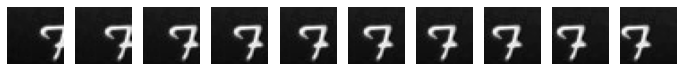

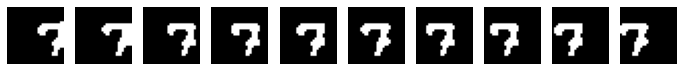

In [230]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im in zip(axes, doss):
    ax.imshow(im, cmap='gray')
    ax.axis('off')  
    
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im in zip(axes, prepro):
    ax.imshow(im, cmap='gray')
    ax.axis('off')    

In [231]:
doss_tensor = torch.Tensor(prepro).view(-1,1,28,28).float()
print(doss_tensor.shape)

torch.Size([10, 1, 28, 28])


In [232]:
_, predicted_doss1 = torch.max(model(doss_tensor),1) 
predicted_doss2 = model(doss_tensor)
predicted_doss2 [predicted_doss2 < 10] = False
# predicted_doss2 [predicted_doss2 > 10] = True
predicted_doss3 = model(doss_tensor)
predicted_avg = predicted_doss3.sum(0)/predicted_doss3.shape[0]        

# If we are able to place a window with the correct size and position we can identify it correctly, (i tested) otherwise, nope because it gets confused with many stuff. So we can spend our time trying to use all the tools that we learned. Or spend the time doing a really robust cnn. For everything

In [233]:
print(predicted_doss1)
print(predicted_doss2)
print(predicted_avg)

tensor([6, 5, 3, 5, 5, 7, 7, 8, 8, 6])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 12.6000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        

In [234]:
# Example
doss = np.array(windows[0]) # example to see how it performs
prepro = preprocess_images(doss, res = True)

In [235]:
doss_tensor = torch.Tensor(prepro).view(-1,1,28,28).float()
print(doss_tensor.shape)

torch.Size([77056, 1, 28, 28])


In [236]:
#  _, predicted_doss1 = torch.max(model(doss_tensor),1) 
predicted_doss2 = model(doss_tensor)
predicted_doss2[predicted_doss2 < 10] = 0.
_, predicted_doss2 = torch.max(predicted_doss2,1) 


#  _, predicted_doss1 = torch.max(model(doss_tensor),1) 
# predicted_doss2 [predicted_doss2 > 10] = True
predicted_doss3 = model(doss_tensor)
predicted_avg = predicted_doss3.sum(0)/predicted_doss3.shape[0]        

In [245]:
# get squares for numbers

# indexes = torch.max(predicted_doss2[:,3] != False 
indexes = predicted_doss2 == 3
squares_left_corners = pos_xy[indexes.numpy()]
print(squares_left_corners.shape)

(784, 2)


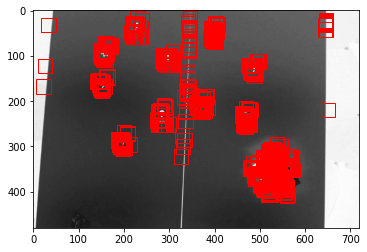

In [246]:
fig, ax = plt.subplots(1) 
ax.imshow(frames[0], cmap='gray')

for squares in squares_left_corners:
    rect = patches.Rectangle((squares),shape_number[1],shape_number[0],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)

plt.show()